In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd -q ..

In [3]:
import lcpfn 
import torch 
import torch as th
import json
import os
import numpy as np
from matplotlib import pyplot as plt

In [86]:
def readDatasetJson(path):
    f = open(path)

    dataset = json.load(f)
    # print(len(dataset))
    
    x = []
    y = []

    for v in dataset.values():
        x.append(v[0])
        y.append(v[1])
        
    x_true = th.Tensor(x)
    y_true = th.Tensor(y)
    
    return x_true, y_true

def find_file(root_dir, target_filename):
    for root, dirs, files in os.walk(root_dir):
        if target_filename in files:
            return os.path.join(root, target_filename)
    
    # If the loop completes without returning, the file was not found
    return None

def find_data():
    return find_file(os.getcwd(), 'data.json')

def get_data():
    return readDatasetJson(find_data())

def get_test_batch(
    batch_size,
    num_features = 1,
    seq_len = 26,
    device = "cpu",
):
    assert num_features == 1

    x_data, y_data = get_data()
   
    x_data = x_data[3302-batch_size:, :]
    y_data = y_data[3302-batch_size:, :]
    
    y_data_noisy = y_data.clone()
    
    x_data = x_data.view((num_features, batch_size, seq_len)).transpose(2, 0).to(device)
    y_data = y_data.transpose(1, 0).to(device)
    y_data_noisy = y_data.clone()

    return x_data, y_data, y_data_noisy

def get_random(num_features=1, seq_len=26, device='cpu'):
    assert num_features == 1
    x_data, y_data = get_data()
    ind = np.random.randint(0, 3302)
    print('ind: ', ind)
    x_data = x_data[ind, :]
    y_data = y_data[ind, :]

    print(x_data.shape)
    print(y_data.shape)

    # x_data = x_data.view((num_features, 1, seq_len)).transpose(2, 0).to(device)
    # y_data = y_data.transpose(1, 0).to(device)
    return x_data, y_data

def get_batch(
    batch_size,
    seq_len,
    num_features,
    device="cpu",
    noisy_target=True,
    **_,
):
    assert num_features == 1

    x_data, y_data = get_data()
    print(x_data.shape)
    x_data = x_data[:batch_size, :]
    y_data = y_data[:batch_size, :]

    y_data_noisy = y_data.clone()

    x_data = x_data.view((num_features, batch_size, seq_len)).transpose(2, 0).to(device)
    y_data = y_data.transpose(1, 0).to(device)
    y_data_noisy = y_data.clone()

    return x_data, y_data, y_data_noisy

## Load trained LC-PFN model

In [87]:
result = lcpfn.train_lcpfn(get_batch_func=get_batch, 
                         seq_len=26,
                         emsize=256,
                         nlayers=12,
                         lr=0.001,
                         batch_size=1651,
                         epochs=0)

result[2].load_state_dict(th.load("/home/patrik/new/dl/reproducibility/deep-learning-project/notebooks/models/model_1651.pth"))
model = result[2]

model = lcpfn.LCPFN(model)

Using cpu:0 device
init dist
Not using distributed
DataLoader.__dict__ {'num_steps': 100, 'get_batch_kwargs': {'batch_size': 1651, 'eval_pos_seq_len_sampler': <function train.<locals>.eval_pos_seq_len_sampler at 0x794f1beeca60>, 'seq_len_maximum': 26, 'device': 'cpu:0', 'num_features': 1, 'hyperparameters': {}}, 'num_features': 1}
torch.Size([3302, 26])
Style definition: None
Using a Transformer with 6.46 M parameters


## Generate a learning curve from the prior

(0.0, 1.0)

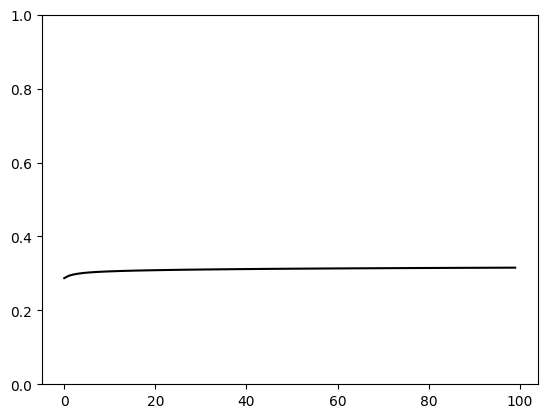

In [88]:
prior = lcpfn.sample_from_prior(np.random)
curve, _ = prior()
plt.plot(curve, "black") 
plt.ylim(0, 1)

## Extrapolate the learning curve with a cutoff of 10% 

In [89]:
curve

array([0.28720967, 0.29362902, 0.29699121, 0.29922236, 0.30083223,
       0.3020508 , 0.30300899, 0.30378867, 0.30444277, 0.30500596,
       0.30550122, 0.30594403, 0.30634505, 0.30671183, 0.30704996,
       0.30736363, 0.30765616, 0.30793018, 0.30818785, 0.30843098,
       0.30866109, 0.30887945, 0.30908719, 0.30928525, 0.30947448,
       0.30965561, 0.30982929, 0.30999608, 0.3101565 , 0.31031101,
       0.31046001, 0.31060387, 0.31074293, 0.31087748, 0.31100781,
       0.31113415, 0.31125675, 0.31137581, 0.31149152, 0.31160406,
       0.3117136 , 0.31182029, 0.31192426, 0.31202566, 0.31212459,
       0.31222118, 0.31231553, 0.31240774, 0.31249789, 0.31258609,
       0.3126724 , 0.31275691, 0.31283969, 0.3129208 , 0.31300031,
       0.31307828, 0.31315476, 0.31322981, 0.31330349, 0.31337583,
       0.31344689, 0.31351671, 0.31358532, 0.31365278, 0.31371911,
       0.31378436, 0.31384855, 0.31391173, 0.31397391, 0.31403513,
       0.31409543, 0.31415481, 0.31421332, 0.31427098, 0.31432

In [118]:
# construct 

# x = torch.arange(1, 101).unsqueeze(1)
# y = torch.from_numpy(curve).float().unsqueeze(1)
# cutoff = 10

x, y = get_random()
x = x.squeeze(dim=-1)
cutoff = 13


ind:  685
torch.Size([26])
torch.Size([26])


In [119]:
x.shape

torch.Size([26])

In [120]:
y.shape

torch.Size([26])

In [121]:
#predictions = model.predict_quantiles(x_train=x[:cutoff], y_train=y[:cutoff], x_test=x[cutoff:], qs=[0.05, 0.5, 0.95])

predictions = model.forward(x_train=x[:cutoff], y_train=y[:cutoff], x_test=x[cutoff:])
predictions = predictions.squeeze(-1)


In [122]:
cutoff

13

In [123]:
y

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9998, 0.9998,
        0.9998, 0.9995, 0.9993, 0.9991, 0.9987, 0.9987, 0.9986, 0.9986, 0.9984,
        0.9981, 0.9981, 0.9980, 0.9979, 0.9979, 0.9979, 0.9977, 0.9975])

In [124]:
pred = predictions.detach().numpy().flatten()
pred

array([1.0124675, 1.0124677, 1.0124693, 1.0124695, 1.0124714, 1.0124748,
       1.0124747, 1.0124801, 1.012485 , 1.0124853, 1.0124857, 1.0124913,
       1.0124958], dtype=float32)

In [125]:
pred.shape

(13,)

In [126]:
xs = x[cutoff:].numpy().flatten()
xs

array([0.3075288 , 0.30899215, 0.3392969 , 0.3406572 , 0.37663916,
       0.43585718, 0.43693423, 0.5344666 , 0.6179843 , 0.62098706,
       0.63018316, 0.7342948 , 0.8092939 ], dtype=float32)

In [127]:
xs.shape

(13,)

In [128]:
x_plot = x.numpy().flatten()

In [129]:
y_plot = y.numpy().flatten()
y_plot

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 0.9998059 , 0.99978   , 0.99975914,
       0.999532  , 0.9992959 , 0.999108  , 0.99873805, 0.998732  ,
       0.9985842 , 0.99857754, 0.99840206, 0.9981133 , 0.998108  ,
       0.9980218 , 0.997948  , 0.99794096, 0.99791944, 0.99767566,
       0.9975    ], dtype=float32)

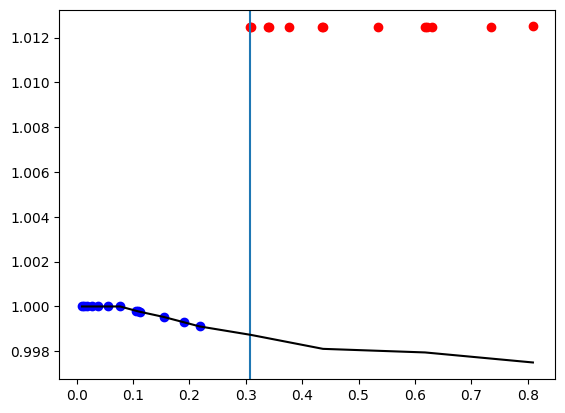

In [130]:
plt.scatter(xs, pred, color='red')
plt.scatter(x[:cutoff], y[:cutoff], color='blue')
plt.axvline(x[cutoff]) 
plt.plot(x_plot, y_plot, color='black')
# plt.ylim([0, max(list(y_plot) + list(pred))])

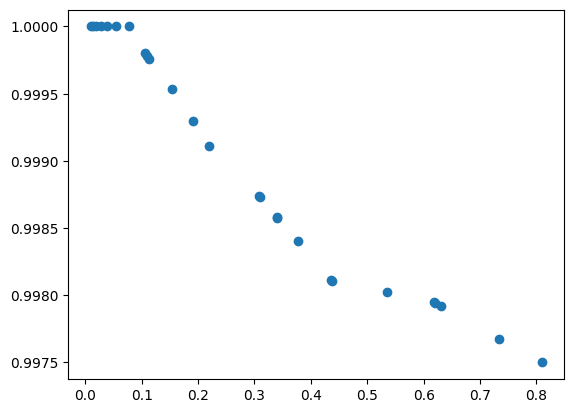

In [131]:
plt.scatter(x_plot, y_plot)